# Obtain all neccessary imports

In [2]:
from IPython import get_ipython;   
# get_ipython().magic('reset -sf')

import numpy as np
import random
import math
import os
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

from numpy import dot, multiply, diag, power
from matplotlib.animation import FuncAnimation
from matplotlib import colors
from matplotlib import animation
from IPython.display import display, HTML

In [3]:
# Add path to the save folder on this system
# Add path to the save folder on this system
if os.name == 'nt':  # Windows
    folder_path = r'c:\Users\steph\Box\ZartmanLabGroupFolder\Zartman_Dowling\Stephen\MC2021_Data'
    sim_folder_path = r'"C:\Users\steph\Box\ZartmanLabGroupFolder\Zartman_Dowling\Stephen\MC2021_Data\simulationResults\Figure_2"'
else:  # macOS/Linux
    folder_path = r'/Users/scini/Library/CloudStorage/Box-Box/ZartmanLabGroupFolder/Zartman_Dowling/Stephen/MC2021_Data'
    sim_folder_path = r'/Users/scini/Library/CloudStorage/Box-Box/ZartmanLabGroupFolder/Zartman_Dowling/Stephen/MC2021_Data/simulationResults/Figure_2'


# Create the pouch class and pouch operations

In [35]:
class Pouch(object): 
    def __init__(self, params=None, size = 'xsmall', sim_number=0, save=False, saveName='default'):
        
        """Class implementing pouch structure and simulating Calcium signaling.
        Inputs:
        
        params (dict)
            A Python dictionary of parameters to simulate with the keys:
            ['K_PLC', 'K_5', 'k_1' , 'k_a', 'k_p', 'k_2', 'V_SERCA', 'K_SERCA', 'c_tot', 'beta', 'k_i', 'D_p', 'tau_max', 'k_tau', 'lower', 'upper','frac', 'D_c_ratio']
        
        size (string)
            Size of the pouch to simulate:
            [xsmall, small, medium, or large]
        
        sim_number (integer)
            Represents ID of a simulation to save the figures with unique names and set the random number generator seed
        
        save (boolean)
            If True, the simulation outputs will be saved
        
        saveName (string)
            Additional distinct name to save the output files as
        
        """
        # Create characteristics of the pouch object
        self.size=size
        self.saveName=saveName
        self.sim_number=sim_number
        self.save=save
        self.param_dict=params
        
        # If parameters are not set, then use baseline values
        if self.param_dict==None:
            self.param_dict={'K_PLC': 0.2, 'K_5':0.66, 'k_1':1.11 , 'k_a': 0.08, 'k_p':0.13, 'k_2':0.0203, 'V_SERCA':0.9, 'K_SERCA':0.1,
            'c_tot':2, 'beta':.185, 'k_i':0.4, 'D_p':0.005, 'tau_max':800, 'k_tau':1.5, 'lower':0.5, 'upper':0.7, 'frac':0.007680491551459293, 'D_c_ratio':0.1}
        
        # If a dictionary is given, assure all parameters are provided
        if sorted([r for r in self.param_dict])!=['D_c_ratio','D_p','K_5','K_PLC','K_SERCA','V_SERCA','beta','c_tot','frac','k_1','k_2','k_a', 'k_i','k_p','k_tau','lower','tau_max','upper']:
            print("Improper parameter input, please assure all parameters are specified")
            return
            
        # Load statics for wing disc geometries    
        disc_vertices = np.load(os.path.join(folder_path, "geometry", "disc_vertices.npy"), allow_pickle=True).item()  # Vertices
        disc_laplacians = np.load(os.path.join(folder_path, "geometry", "disc_sizes_laplacian.npy"), allow_pickle=True).item()  # Laplacian Matrix
        disc_adjs = np.load(os.path.join(folder_path, "geometry", "disc_sizes_adj.npy"), allow_pickle=True).item()  # Adjacency matrix
        
        self.adj_matrix=disc_adjs[self.size] # Adjacency Matrix
        self.laplacian_matrix=disc_laplacians[size] # Laplacian Matrix
        self.new_vertices=disc_vertices[size] # Vertices
        
        # Establish characteristics of the pouch for simulations
        self.n_cells=self.adj_matrix.shape[0] # Number of cells in the pouch
        self.dt=.2 # Time step for ODE approximations
        self.T=int(3600/self.dt) # Simulation to run for 3600 seconds (1 hour) 
        
        # Establish baseline parameter values for the simulation
        self.K_PLC=self.param_dict['K_PLC']  # .2
        self.K_5=self.param_dict['K_5'] # 0.66
        self.k_1=self.param_dict['k_1'] # 1.11
        self.k_a=self.param_dict['k_a'] # 0.08
        self.k_p=self.param_dict['k_p'] # 0.13
        self.k_2=self.param_dict['k_2'] # 0.0203
        self.V_SERCA=self.param_dict['V_SERCA'] # .9
        self.K_SERCA=self.param_dict['K_SERCA'] # .1
        self.c_tot=self.param_dict['c_tot'] # 2
        self.beta=self.param_dict['beta'] # .185
        self.k_i=self.param_dict['k_i'] # 0.4
        self.D_p =self.param_dict['D_p'] # 0.005
        self.D_c =self.param_dict['D_c_ratio']*self.D_p
        self.tau_max=self.param_dict['tau_max'] # 800
        self.k_tau=self.param_dict['k_tau'] # 1.5
        self.lower=self.param_dict['lower'] # Lower bound of standby cell VPLCs
        self.upper=self.param_dict['upper'] # Upper bound of standy cell VPLCs
        self.frac=self.param_dict['frac']   # Fraction of initiator cells

        self.disc_dynamics=np.zeros((self.n_cells,4,self.T)) # Initialize disc_dynamics to save simulation calcium, IP3, calcium_ER, ratio
        self.VPLC_state=np.zeros((self.n_cells,1)) # Initialize VPLC array for cells
    
    def simulate(self): # Simulate dynamics of system
            np.random.seed(self.sim_number) # Set the seed for reproducibility (keep initiator cells consistent each run)
            
            self.disc_dynamics[:,2,0] = (self.c_tot-self.disc_dynamics[:,0,0])/self.beta # Initialize simulation ER Calcium
            self.disc_dynamics[:,3,0]=np.random.uniform(.5,.7,size=(self.n_cells,1)).T # Initialize simulation fraction of inactivated IP3R receptors
            self.VPLC_state=np.random.uniform(self.lower,self.upper,(self.n_cells,1)) # Initialize the values for VPLCs of standby cells to be random uniformly distributed from lower to upper
            stimulated_cell_idxs=np.random.choice(self.n_cells, int(self.frac*self.n_cells)) # Choose which cells are initiator cells
            self.VPLC_state[stimulated_cell_idxs,0]=np.random.uniform(1.3,1.5,len(stimulated_cell_idxs)) # Set the VPLC of initiator cells to be random uniformly distributed between 1.3 and 1.5
            
            V_PLC=self.VPLC_state.reshape((self.n_cells,1)) # Establish the VPLCs to be passed into the ODE approximations
            
            # ODE approximation solving
            for step in range(1,self.T):
                # ARRAY REFORMATTING
                ca=self.disc_dynamics[:,0,step-1].reshape(-1,1)
                ipt=self.disc_dynamics[:,1,step-1].reshape(-1,1)
                s=self.disc_dynamics[:,2,step-1].reshape(-1,1)
                r=self.disc_dynamics[:,3,step-1].reshape(-1,1)
                ca_laplacian=self.D_c*np.dot(self.laplacian_matrix,ca)
                ipt_laplacian=self.D_p*np.dot(self.laplacian_matrix,ipt)
                
                # ODE EQUATIONS
                self.disc_dynamics[:,0,step]=(ca+self.dt*(ca_laplacian+(self.k_1*(np.divide(np.divide(r*np.multiply(ca,ipt),(self.k_a+ca)),(self.k_p+ipt)))**3 +self.k_2)*(s-ca)-self.V_SERCA*(ca**2)/(ca**2+self.K_SERCA**2))).T
                self.disc_dynamics[:,1,step]=(ipt+self.dt*(ipt_laplacian+np.multiply(V_PLC,np.divide(ca**2,(ca**2+self.K_PLC**2)))-self.K_5*ipt)).T
                self.disc_dynamics[:,2,step]=((self.c_tot-ca)/self.beta).T
                self.disc_dynamics[:,3,step]=(r+self.dt*((self.k_tau**4+ca**4)/(self.tau_max*self.k_tau**4))*((1-r*(self.k_i+ca)/self.k_i))).T

    def simulate_optogenetic(self): # Simulate dynamics of system
        np.random.seed(self.sim_number) # Set the seed for reproducibility (keep initiator cells consistent each run)

        # Add optogenetic stimulation using np.interp
        # Create a time vector for the simulation
        T = 3600
        dt = 0.2       
        # Create the full time vector for 1 hour (3600 seconds)
        time_vector = np.arange(0, T, dt)

        # Define cycle duration and on/off durations
        cycle_duration = 120  # seconds
        on_duration = 60  # seconds
        off_duration = cycle_duration - on_duration

        # Create a vector for the optogenetic stimulation with 30 seconds on and 30 seconds off, starting with "off"
        opto_time_vector = np.arange(0, T, dt)
        opto_stimulation = np.zeros_like(opto_time_vector)
        for i in range(len(opto_time_vector)):
            if (i * dt) % cycle_duration >= off_duration:
                opto_stimulation[i] = 1

        # Interpolate the optogenetic stimulation to match the simulation time vector
        opto_stimulation_interp = np.interp(time_vector, opto_time_vector, opto_stimulation)

        # # Plot
        # plt.figure(figsize=(10, 5))
        # plt.plot(time_vector, opto_stimulation_interp, label='Optogenetic Stimulation')
        # plt.title('Optogenetic Stimulation Over Time (30s On/30s Off, Starting with Off)')
        # plt.xlabel('Time (s)')
        # plt.ylabel('Stimulation')
        # plt.legend()
        # plt.show()

        
        self.disc_dynamics[:,2,0] = (self.c_tot-self.disc_dynamics[:,0,0])/self.beta # Initialize simulation ER Calcium
        self.disc_dynamics[:,3,0]=np.random.uniform(.5,.7,size=(self.n_cells,1)).T # Initialize simulation fraction of inactivated IP3R receptors
        self.VPLC_state=np.random.uniform(self.lower,self.upper,(self.n_cells,1)) # Initialize the values for VPLCs of standby cells to be random uniformly distributed from lower to upper
        stimulated_cell_idxs=np.random.choice(self.n_cells, int(self.frac*self.n_cells)) # Choose which cells are initiator cells
        self.VPLC_state[stimulated_cell_idxs,0]=np.random.uniform(0.5,0.7,len(stimulated_cell_idxs)) # Set the VPLC of initiator cells to be random uniformly distributed between 1.3 and 1.5
        # # Add optogenetic stimulation to the VPLC state of the initiator cells
        # self.VPLC_state[stimulated_cell_idxs,0] += opto_stimulation_interp[0] * 0.5  # Add 0.5 to the VPLC state of the initiator cells when stimulated
        
        V_PLC=self.VPLC_state.reshape((self.n_cells,1)) # Establish the VPLCs to be passed into the ODE approximations
        
        # ODE approximation solving
        for step in range(1,self.T):
            # ARRAY REFORMATTING
            ca=self.disc_dynamics[:,0,step-1].reshape(-1,1)
            ipt=self.disc_dynamics[:,1,step-1].reshape(-1,1)
            s=self.disc_dynamics[:,2,step-1].reshape(-1,1)
            r=self.disc_dynamics[:,3,step-1].reshape(-1,1)
            ca_laplacian=self.D_c*np.dot(self.laplacian_matrix,ca)
            ipt_laplacian=self.D_p*np.dot(self.laplacian_matrix,ipt)
            
            # ODE EQUATIONS
            self.disc_dynamics[:,0,step]=(ca+self.dt*(ca_laplacian+(self.k_1*(np.divide(np.divide(r*np.multiply(ca,ipt),(self.k_a+ca)),(self.k_p+ipt)))**3 +self.k_2)*(s-ca)-self.V_SERCA*(ca**2)/(ca**2+self.K_SERCA**2))).T
            self.disc_dynamics[:,1,step]=(ipt+self.dt*(ipt_laplacian+np.multiply(V_PLC,np.divide(ca**2,(ca**2+self.K_PLC**2)))-self.K_5*ipt)).T
            self.disc_dynamics[stimulated_cell_idxs,1,step]=(ipt+self.dt*(ipt_laplacian+np.multiply(V_PLC,np.divide(ca**2,(ca**2+self.K_PLC**2)))-self.K_5*ipt)+ opto_stimulation_interp[step]).T
            # self.disc_dynamics[:, 1,step] += opto_stimulation_interp[step]  # Add opto stimulation to initiator cells

            self.disc_dynamics[:,2,step]=((self.c_tot-ca)/self.beta).T
            self.disc_dynamics[:,3,step]=(r+self.dt*((self.k_tau**4+ca**4)/(self.tau_max*self.k_tau**4))*((1-r*(self.k_i+ca)/self.k_i))).T
            
    def make_animation(self, path=sim_folder_path): # Creation of calcium video
        colormap = plt.cm.Greens
        normalize = matplotlib.colors.Normalize(vmin=np.min(self.disc_dynamics[:,0,:]), vmax=max(np.max(self.disc_dynamics[:,0,:]),1))
        with sns.axes_style("white"):
                fig=plt.figure(figsize=(25,15))
                fig.patch.set_alpha(0.)
                ax = fig.add_subplot(1,1,1)
                ax.axis('off')
                sm = plt.cm.ScalarMappable(cmap=colormap, norm=normalize)
                sm._A = []
                cbar=fig.colorbar(sm, ax=ax)
                cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(), fontsize=15,fontweight="bold")
                for cell in self.new_vertices:
                    ax.plot(cell[:,0],cell[:,1], linewidth=0.0, color='w', alpha = 0.0)
                patches = [matplotlib.patches.Polygon(verts) for verts in self.new_vertices ]
                def time_stamp_gen(n):
                    j=0
                    while j < n: # 0.2 sec interval to 1 hour time lapse
                        yield "Elapsed time: "+'{0:02.0f}:{1:02.0f}'.format(*divmod(j*self.dt , 60))
                        j+= 50
                time_stamps=time_stamp_gen(self.T)
                def init():
                    return [ax.add_patch(p) for p in patches]

                def animate(frame,time_stamps):
                    for j in range(len(patches)):
                        c=colors.to_hex(colormap(normalize(frame[j])), keep_alpha=False)
                        patches[j].set_facecolor(c)
                    ax.set_title( next(time_stamps) ,fontsize=50, fontweight="bold")
                    return patches

                anim = animation.FuncAnimation(fig, animate, 
                                               init_func=init, 
                                               frames=self.disc_dynamics[:,0,::50].T, # Disc dynamics: Array of: [n cells x 4 x time-samples]
                                               fargs=(time_stamps,),
                                               interval=70,
                                               blit=True)
        if self.save:
            if path!=None:
                if not os.path.exists(path):
                    os.makedirs(path)
                anim.save(path+"/"+self.size+'Disc_'+str(self.sim_number)+'_'+self.saveName+'.mp4')
            else:
                print("Provide a path for saving videos")
        
    def draw_profile(self, path=sim_folder_path): # Draw the VPLC Profile for the simulation
        colormap = plt.cm.Blues
        normalize = matplotlib.colors.Normalize(vmin=.0, vmax=1.5)
        with sns.axes_style("white"):
                fig=plt.figure(figsize=(45,25))
                ax = fig.add_subplot(1,1,1)
                ax.axis('off')
                fig.patch.set_alpha(0.)
                sm = plt.cm.ScalarMappable(cmap=colormap, norm=normalize)
                sm._A = []
                cbar=fig.colorbar(sm, ax=ax)
                cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(), fontsize=80,fontweight="bold" )
                for cell in self.new_vertices:
                    ax.plot(cell[:,0],cell[:,1], linewidth=1.0, color='black')
                for k in range(len(self.new_vertices)):
                        cell=self.new_vertices[k]
                        c=colors.to_hex(colormap(normalize(self.VPLC_state[k]))[0], keep_alpha=False)
                        ax.fill(cell[:,0],cell[:,1], c)

        if self.save:
            if path!=None:
                if not os.path.exists(path):
                    os.makedirs(path)
                fig.savefig(path+"/"+self.size+'Disc_VPLCProfile_'+str(self.sim_number)+'_'+self.saveName+".png",transparent=True, bbox_inches="tight")
            else:
                print("Provide a path for saving images")
    
    def draw_kymograph(self, path=sim_folder_path): # Draw the calcium Kymograph for the simulation
        with sns.axes_style("white"):
            centeriods= np.zeros((self.adj_matrix.shape[0],2))
            for j in range(self.adj_matrix.shape[0]):
                x_center, y_center=self.new_vertices[j].mean(axis=0)
                centeriods[j,0],centeriods[j,1]=x_center, y_center
            y_axis=centeriods[:,1]
            kymograp_index=np.where((y_axis<(-490)) & (y_axis>(-510))) # Location of where to draw the kymograph line

            colormap = plt.cm.Greens
            normalize = matplotlib.colors.Normalize(vmin=np.min(self.disc_dynamics[:,0,:]), vmax=max(1,np.max(self.disc_dynamics[:,0,:])))
            fig=plt.figure(figsize=(30,10))
            kymograph=self.disc_dynamics[kymograp_index,0,::][0][:,::2]
            kymograph=np.repeat(kymograph,60,axis=0)

            plt.imshow(kymograph.T,cmap=colormap,norm=normalize)
            ax = plt.gca()
            plt.yticks(np.arange(0,self.T/2,1498) , [0,10,20,30,40,50,60],fontsize=30, fontweight="bold")
            plt.xticks([])
            plt.ylabel('Time (min)',fontsize=30,fontweight='bold')
            if self.size=='xsmall':
                plt.xlabel('Position',fontsize=20,fontweight='bold')
            else:
                plt.xlabel('Position',fontsize=30,fontweight='bold')
            
            if self.save:
                if path!=None:
                    if not os.path.exists(path):
                        os.makedirs(path)
                    fig.savefig(path+"/"+self.size+'Disc_Kymograph_'+str(self.sim_number)+'_'+self.saveName+".png",transparent=True, bbox_inches="tight")
                else:
                    print("Provide a path for saving images")

        del kymograph

    def draw_kymograph_transpose(self, path=sim_folder_path): # Draw the calcium Kymograph for the simulation
        with sns.axes_style("white"):
            centeriods= np.zeros((self.adj_matrix.shape[0],2))
            for j in range(self.adj_matrix.shape[0]):
                y_center, x_center=self.new_vertices[j].mean(axis=0)
                centeriods[j,0],centeriods[j,1]=y_center, x_center
            x_axis=centeriods[:,1]
            kymograp_index=np.where((x_axis<(-490)) & (x_axis>(-510))) # Location of where to draw the kymograph line

            colormap = plt.cm.Greens
            normalize = matplotlib.colors.Normalize(vmin=np.min(self.disc_dynamics[:,0,:]), vmax=max(1,np.max(self.disc_dynamics[:,0,:])))
            fig=plt.figure(figsize=(20,30))
            kymograph=self.disc_dynamics[kymograp_index,0,::][0][:,::2]
            kymograph=np.repeat(kymograph,60,axis=0)

            plt.imshow(kymograph.T,cmap=colormap,norm=normalize)
            ax = plt.gca()
            plt.xticks(np.arange(0,self.T/2,1498) , [0,10,20,30,40,50,60],fontsize=30, fontweight="bold")
            plt.yticks([])
            plt.xlabel('Time (min)',fontsize=30,fontweight='bold')
            if self.size=='xsmall':
                plt.ylabel('Spike Position',fontsize=20,fontweight='bold')
            else:
                plt.ylabel('Spike Position',fontsize=30,fontweight='bold')
            
            if self.save:
                if path!=None:
                    if not os.path.exists(path):
                        os.makedirs(path)
                    fig.savefig(path+"/"+self.size+'Disc_Kymograph_'+str(self.sim_number)+'_'+self.saveName+".png",transparent=True, bbox_inches="tight")
                else:
                    print("Provide a path for saving images")

        del kymograph

# Establish simulation parameters to replicate four calcium patterns
### NOTE:
All wings are 'large' wings where the only difference in simulation parameters is the increasing range of $V_{PLC}$ values for standby cells. Initiator cells are the same for each simulation, which is determined by the same random number generator seed.

In [26]:
frac = 1/(195)**0.8
print(frac)

0.014722186359537384


In [27]:
sim_params_Spikes={'K_PLC': 0.2, 'K_5':0.66, 'k_1':1.11 , 'k_a': 0.08, 'k_p':0.13, 'k_2':0.0203, 'V_SERCA':0.9, 'K_SERCA':0.1,
            'c_tot':2, 'beta':.185, 'k_i':0.4, 'D_p':0.005, 'tau_max':800, 'k_tau':1.5, 'lower':0.1, 'upper':0.5,'frac':frac, 'D_c_ratio':0.1}

sim_params_ICT={'K_PLC': 0.2, 'K_5':0.66, 'k_1':1.11 , 'k_a': 0.08, 'k_p':0.13, 'k_2':0.0203, 'V_SERCA':0.9, 'K_SERCA':0.1,
            'c_tot':2, 'beta':.185, 'k_i':0.4, 'D_p':0.005, 'tau_max':800, 'k_tau':1.5, 'lower':0.25, 'upper':0.6,'frac':frac, 'D_c_ratio':0.1}

sim_params_ICW={'K_PLC': 0.2, 'K_5':0.66, 'k_1':1.11 , 'k_a': 0.08, 'k_p':0.13, 'k_2':0.0203, 'V_SERCA':0.9, 'K_SERCA':0.1,
            'c_tot':2, 'beta':.185, 'k_i':0.4, 'D_p':0.005, 'tau_max':800, 'k_tau':1.5, 'lower':0.4, 'upper':0.8,'frac':frac, 'D_c_ratio':0.1}

sim_params_Fluttering={'K_PLC': 0.2, 'K_5':0.66, 'k_1':1.11 , 'k_a': 0.08, 'k_p':0.13, 'k_2':0.0203, 'V_SERCA':0.9, 'K_SERCA':0.1,
            'c_tot':2, 'beta':.185, 'k_i':0.4, 'D_p':0.005, 'tau_max':800, 'k_tau':1.5, 'lower':1.4, 'upper':1.5,'frac':frac, 'D_c_ratio':0.1}

saveFolderName = folder_path+'\simulationResults\Figure_2' # The folder where simulation results are to be saved for this notebook
if not os.path.exists(saveFolderName): # Create the folder if it does not yet exist
    os.makedirs(saveFolderName)

# Create the pouch objects for each calcium pattern

In [36]:
p_Spikes=Pouch(params=sim_params_Spikes, size='small', sim_number=12345, save=True, saveName='Fig_2_Spikes') 
p_ICT=Pouch(params=sim_params_ICT, size='xsmall', sim_number=12345, save=True, saveName='Fig_2_ICT') 
p_ICW=Pouch(params=sim_params_ICW, size='small', sim_number=12345, save=True, saveName='Fig_2_ICW') 
p_Fluttering=Pouch(params=sim_params_Fluttering, size='xsmall', sim_number=12345, save=True, saveName='Fig_2_Fluttering') 

# Run simulations for each of the calcium patterns

In [37]:
p_Spikes.simulate()
p_ICT.simulate()
p_ICW.simulate()
p_Fluttering.simulate()

In [21]:
# p_Spikes_opt=Pouch(params=sim_params_Spikes, size='xsmall', sim_number=12345, save=True, saveName='Fig_2_Spikes_opt') 
# p_ICT_opt=Pouch(params=sim_params_ICT, size='xsmall', sim_number=12345, save=True, saveName='Fig_2_ICT_opt') 
# p_ICW_opt=Pouch(params=sim_params_ICW, size='xsmall', sim_number=12345, save=True, saveName='Fig_2_ICW_opt') 
# p_Fluttering_opt=Pouch(params=sim_params_Fluttering, size='xsmall', sim_number=12345, save=True, saveName='Fig_2_Fluttering_opt') 

# # Do simulations with the optogenetic stimulation
# p_Spikes_opt.simulate_optogenetic()
# p_ICT_opt.simulate_optogenetic()
# p_ICW_opt.simulate_optogenetic()
# p_Fluttering_opt.simulate_optogenetic()


# Draw the $V_{PLC}$ proflies for each of the wings

/var/folders/v2/s6clf_y12bjd0pq98kr66skw0000gs/T/ipykernel_57849/2596856788.py:226: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(), fontsize=80,fontweight="bold" )


ValueError: 'blk' is not a valid value for color: supported inputs are (r, g, b) and (r, g, b, a) 0-1 float tuples; '#rrggbb', '#rrggbbaa', '#rgb', '#rgba' strings; named color strings; string reprs of 0-1 floats for grayscale values; 'C0', 'C1', ... strings for colors of the color cycle; and pairs combining one of the above with an alpha value

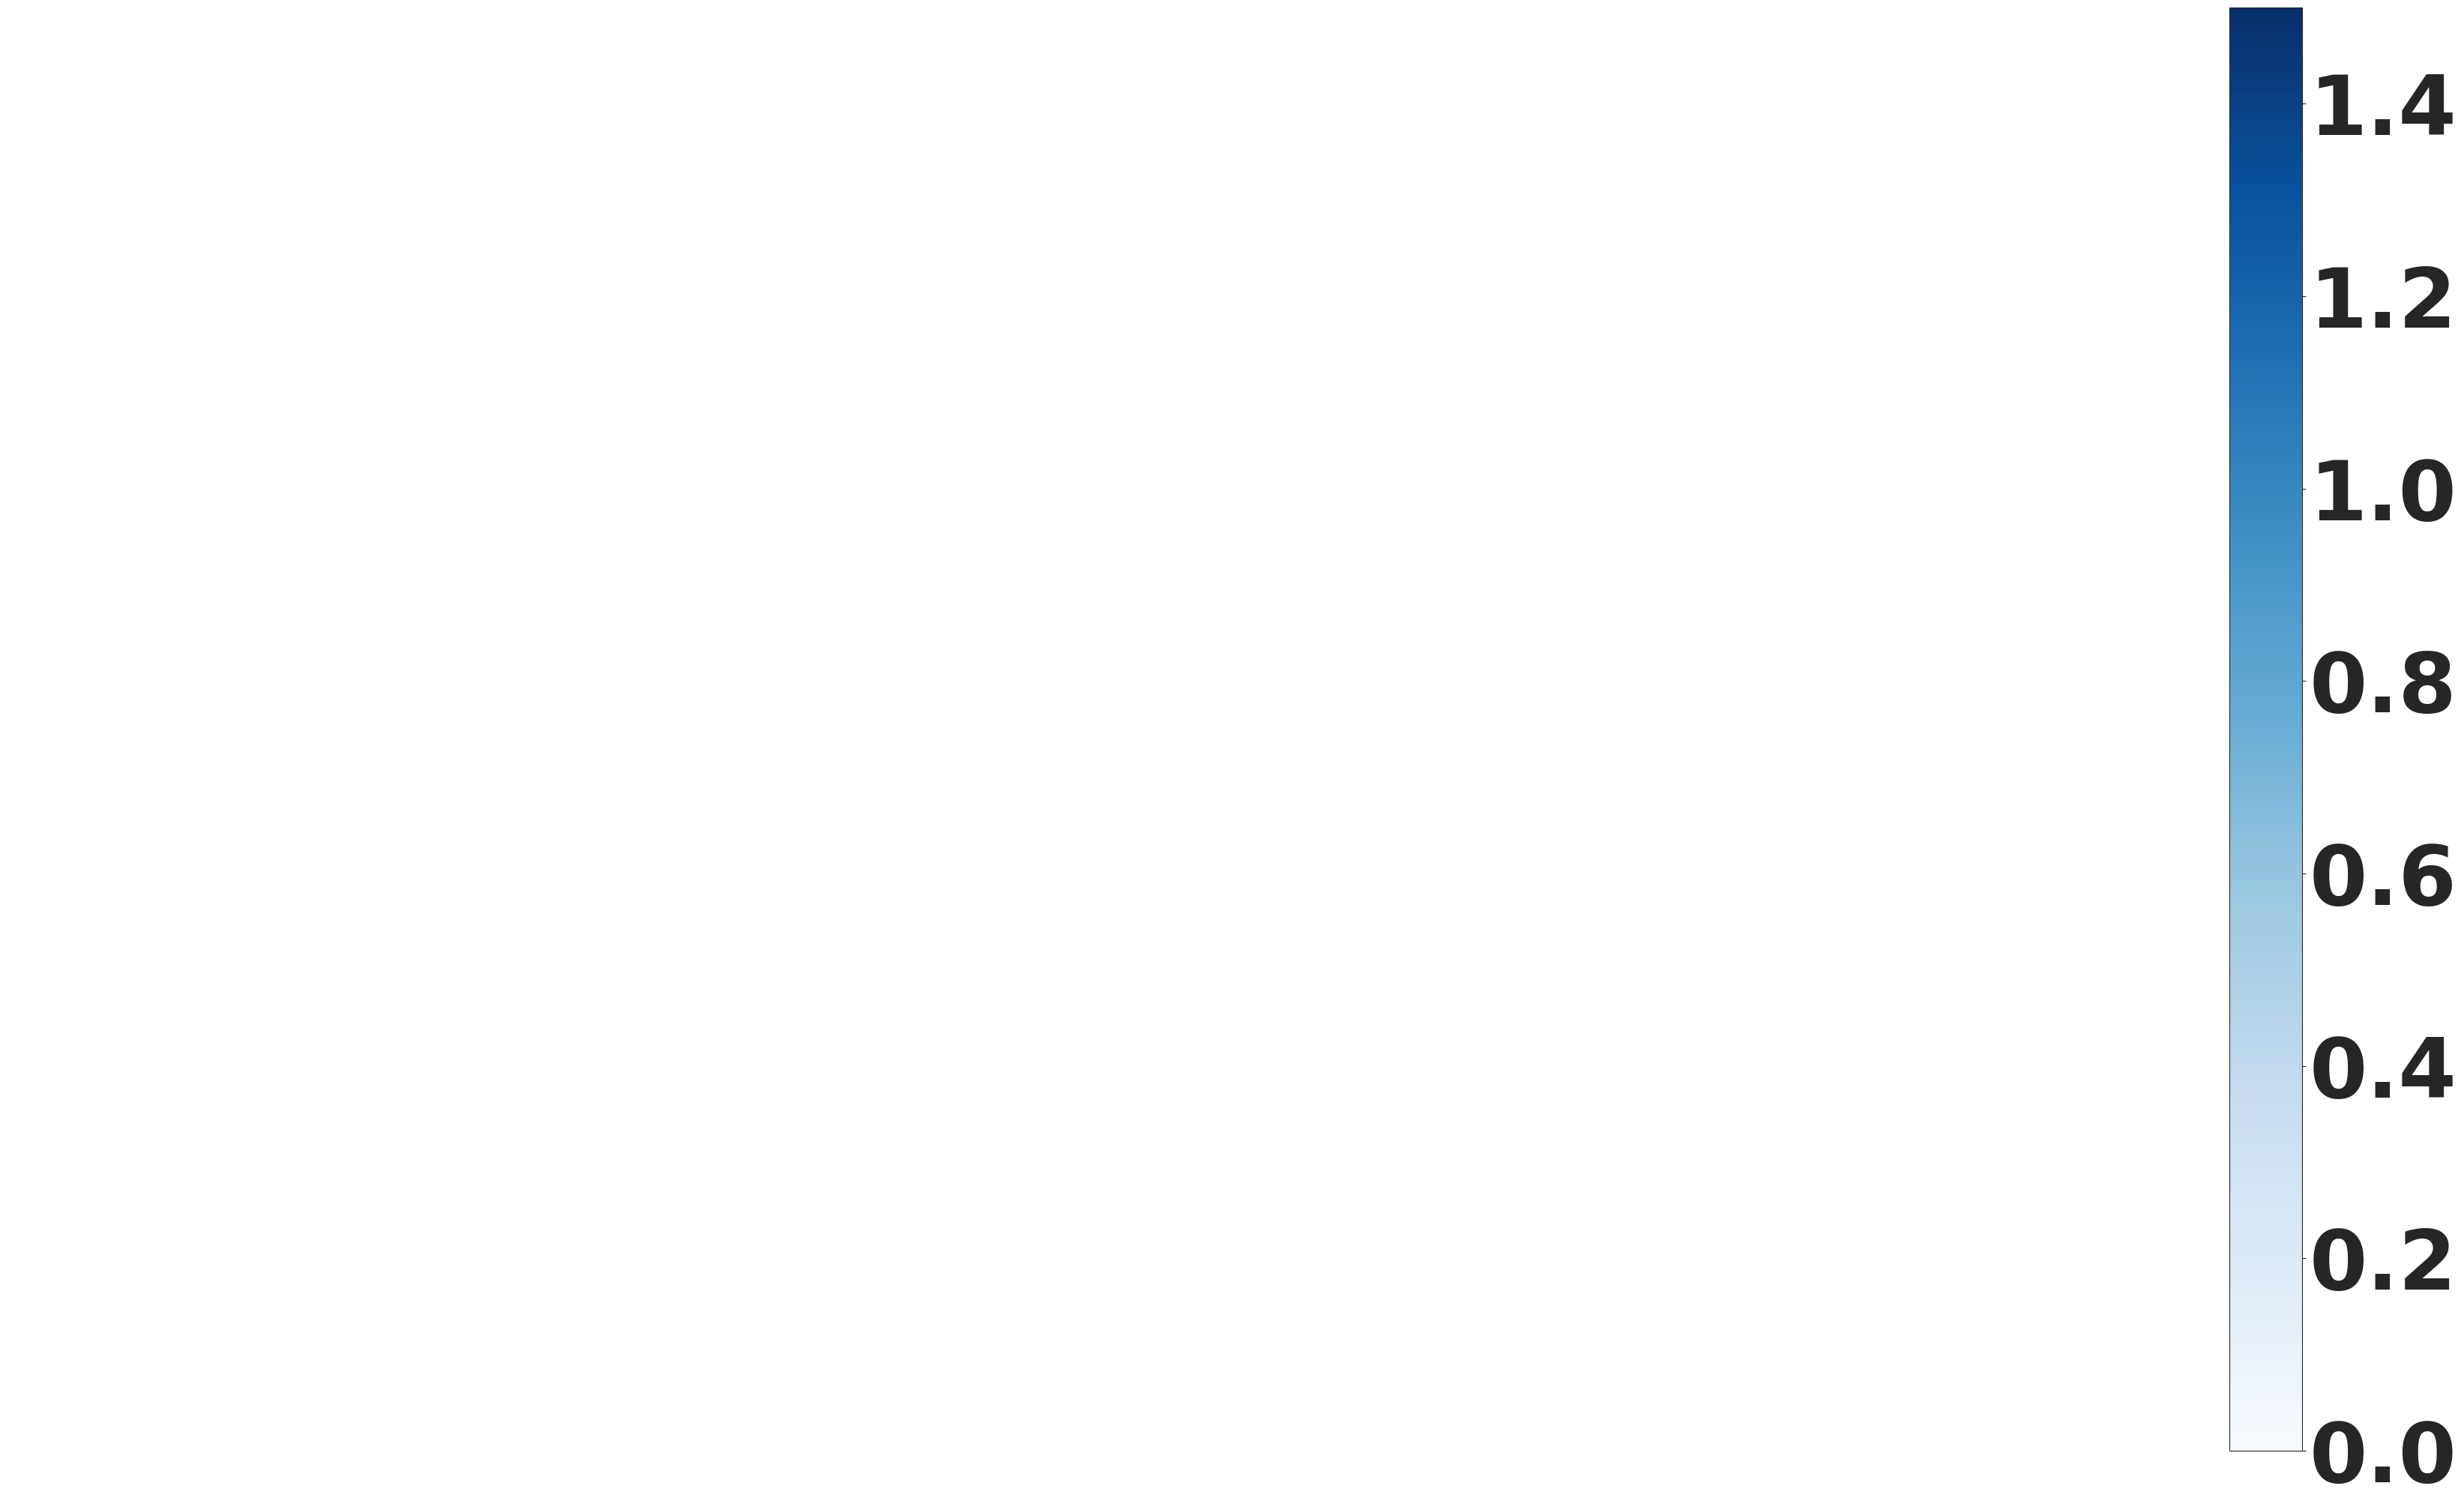

In [31]:
p_Spikes.draw_profile(saveFolderName)
p_ICT.draw_profile(saveFolderName)
p_ICW.draw_profile(saveFolderName)
p_Fluttering.draw_profile(saveFolderName)

# p_Spikes_opt.draw_profile(saveFolderName)
# p_ICT_opt.draw_profile(saveFolderName)
# p_ICW_opt.draw_profile(saveFolderName)
# p_Fluttering_opt.draw_profile(saveFolderName)

# Draw the calcium kymographs for each of the wings

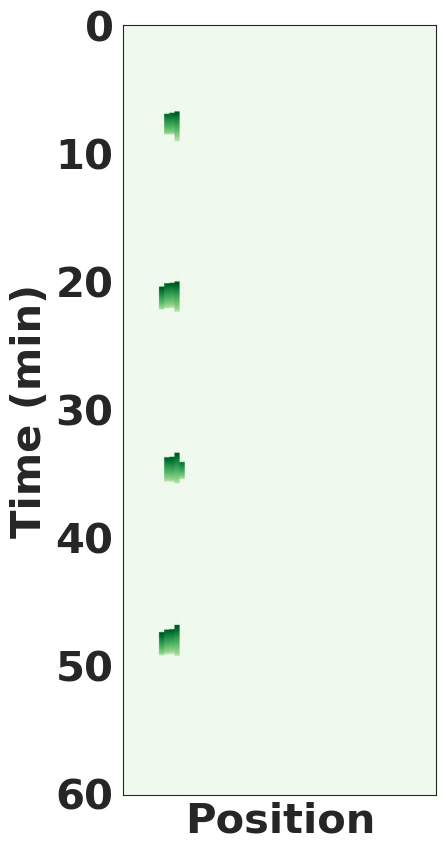

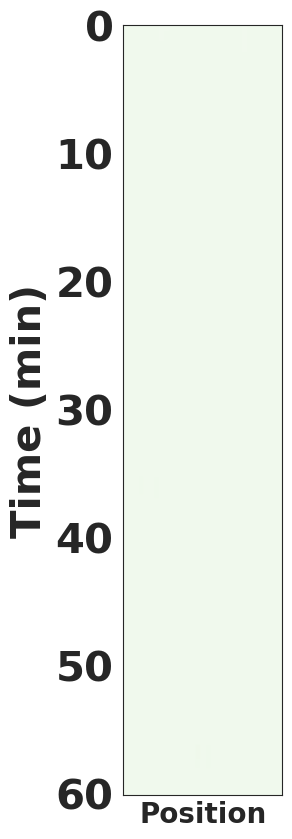

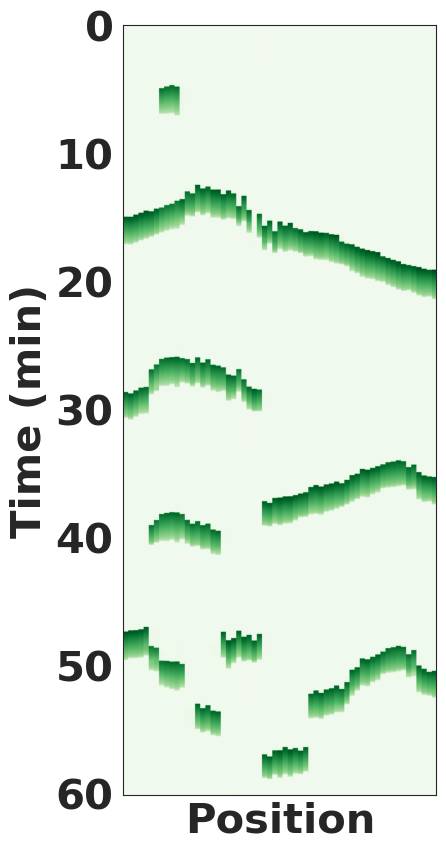

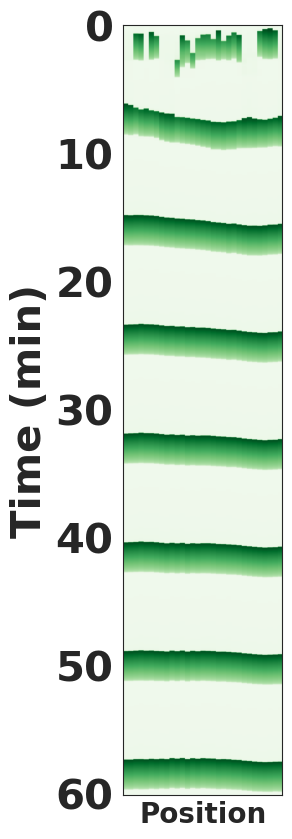

In [32]:
p_Spikes.draw_kymograph(saveFolderName)
p_ICT.draw_kymograph(saveFolderName)
p_ICW.draw_kymograph(saveFolderName)
p_Fluttering.draw_kymograph(saveFolderName)

# p_Spikes_opt.draw_kymograph(saveFolderName)
# p_ICT_opt.draw_kymograph(saveFolderName)
# p_ICW_opt.draw_kymograph(saveFolderName)
# p_Fluttering_opt.draw_kymograph(saveFolderName)

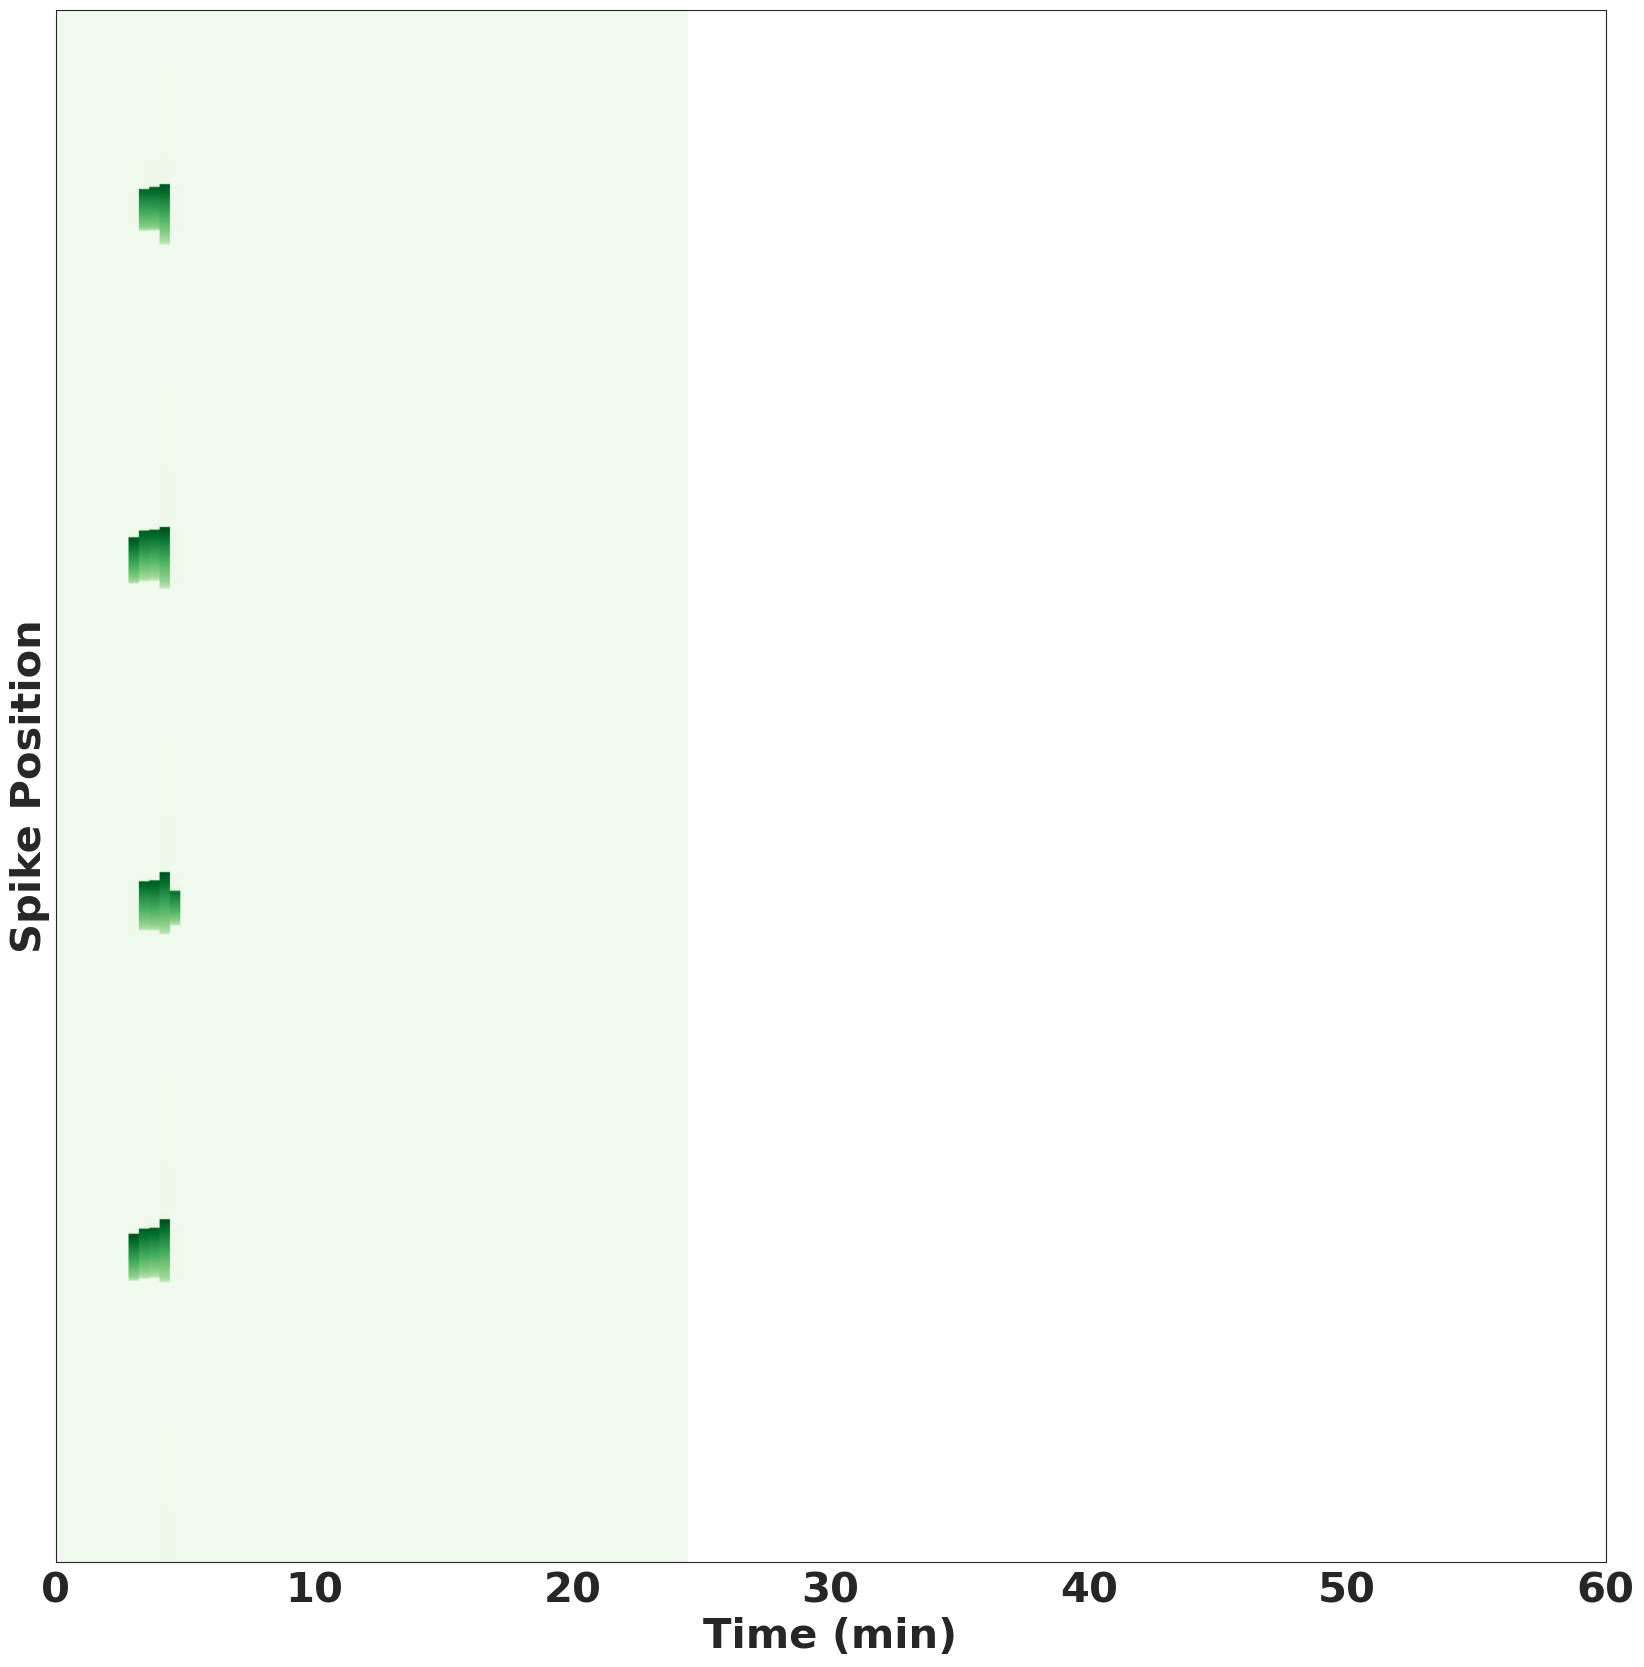

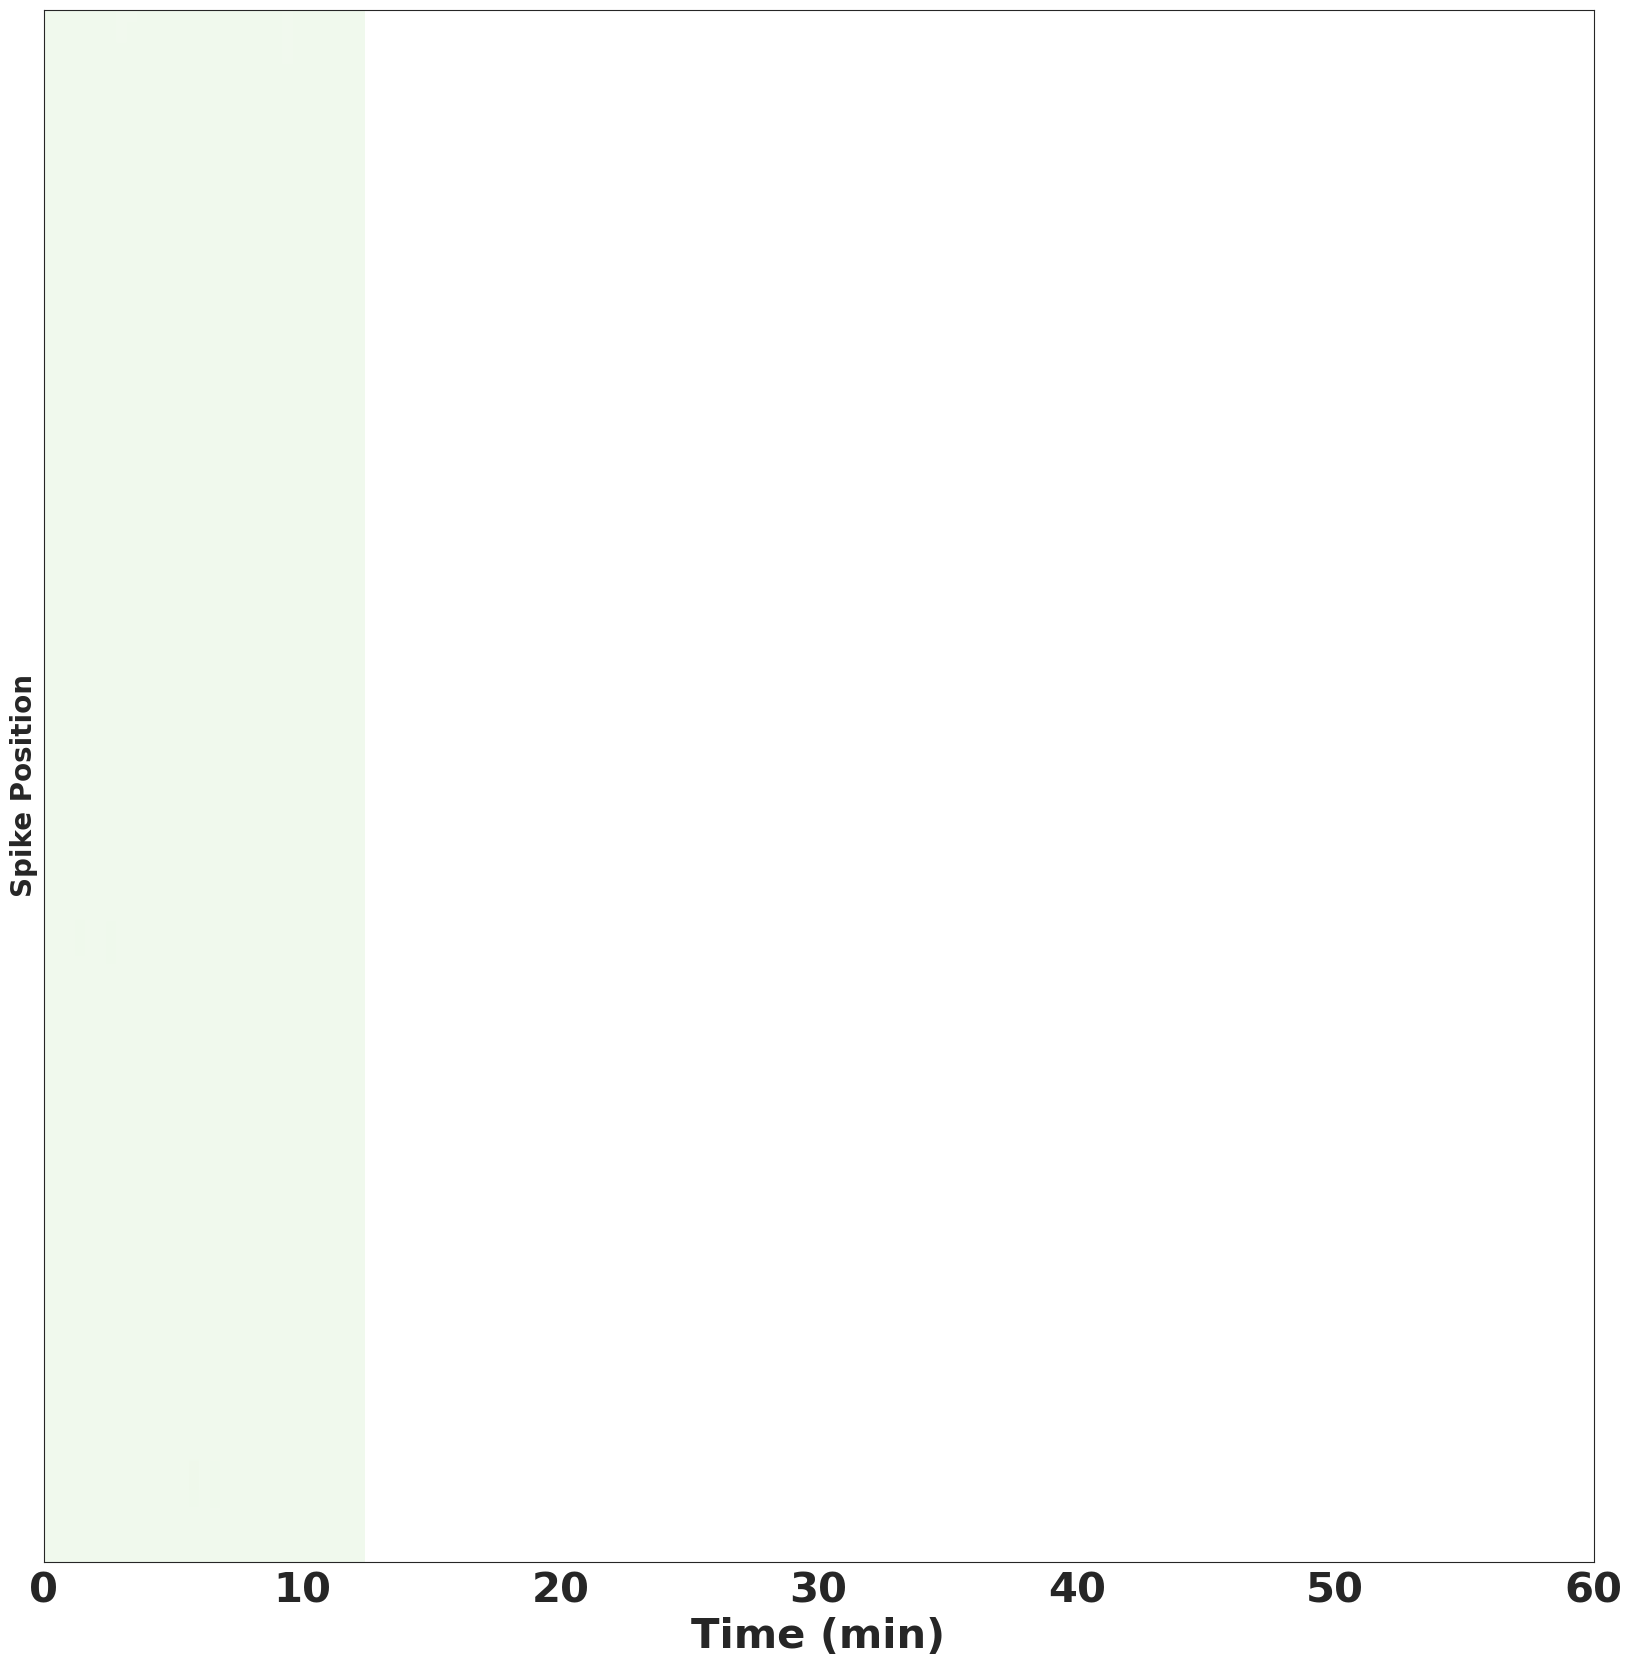

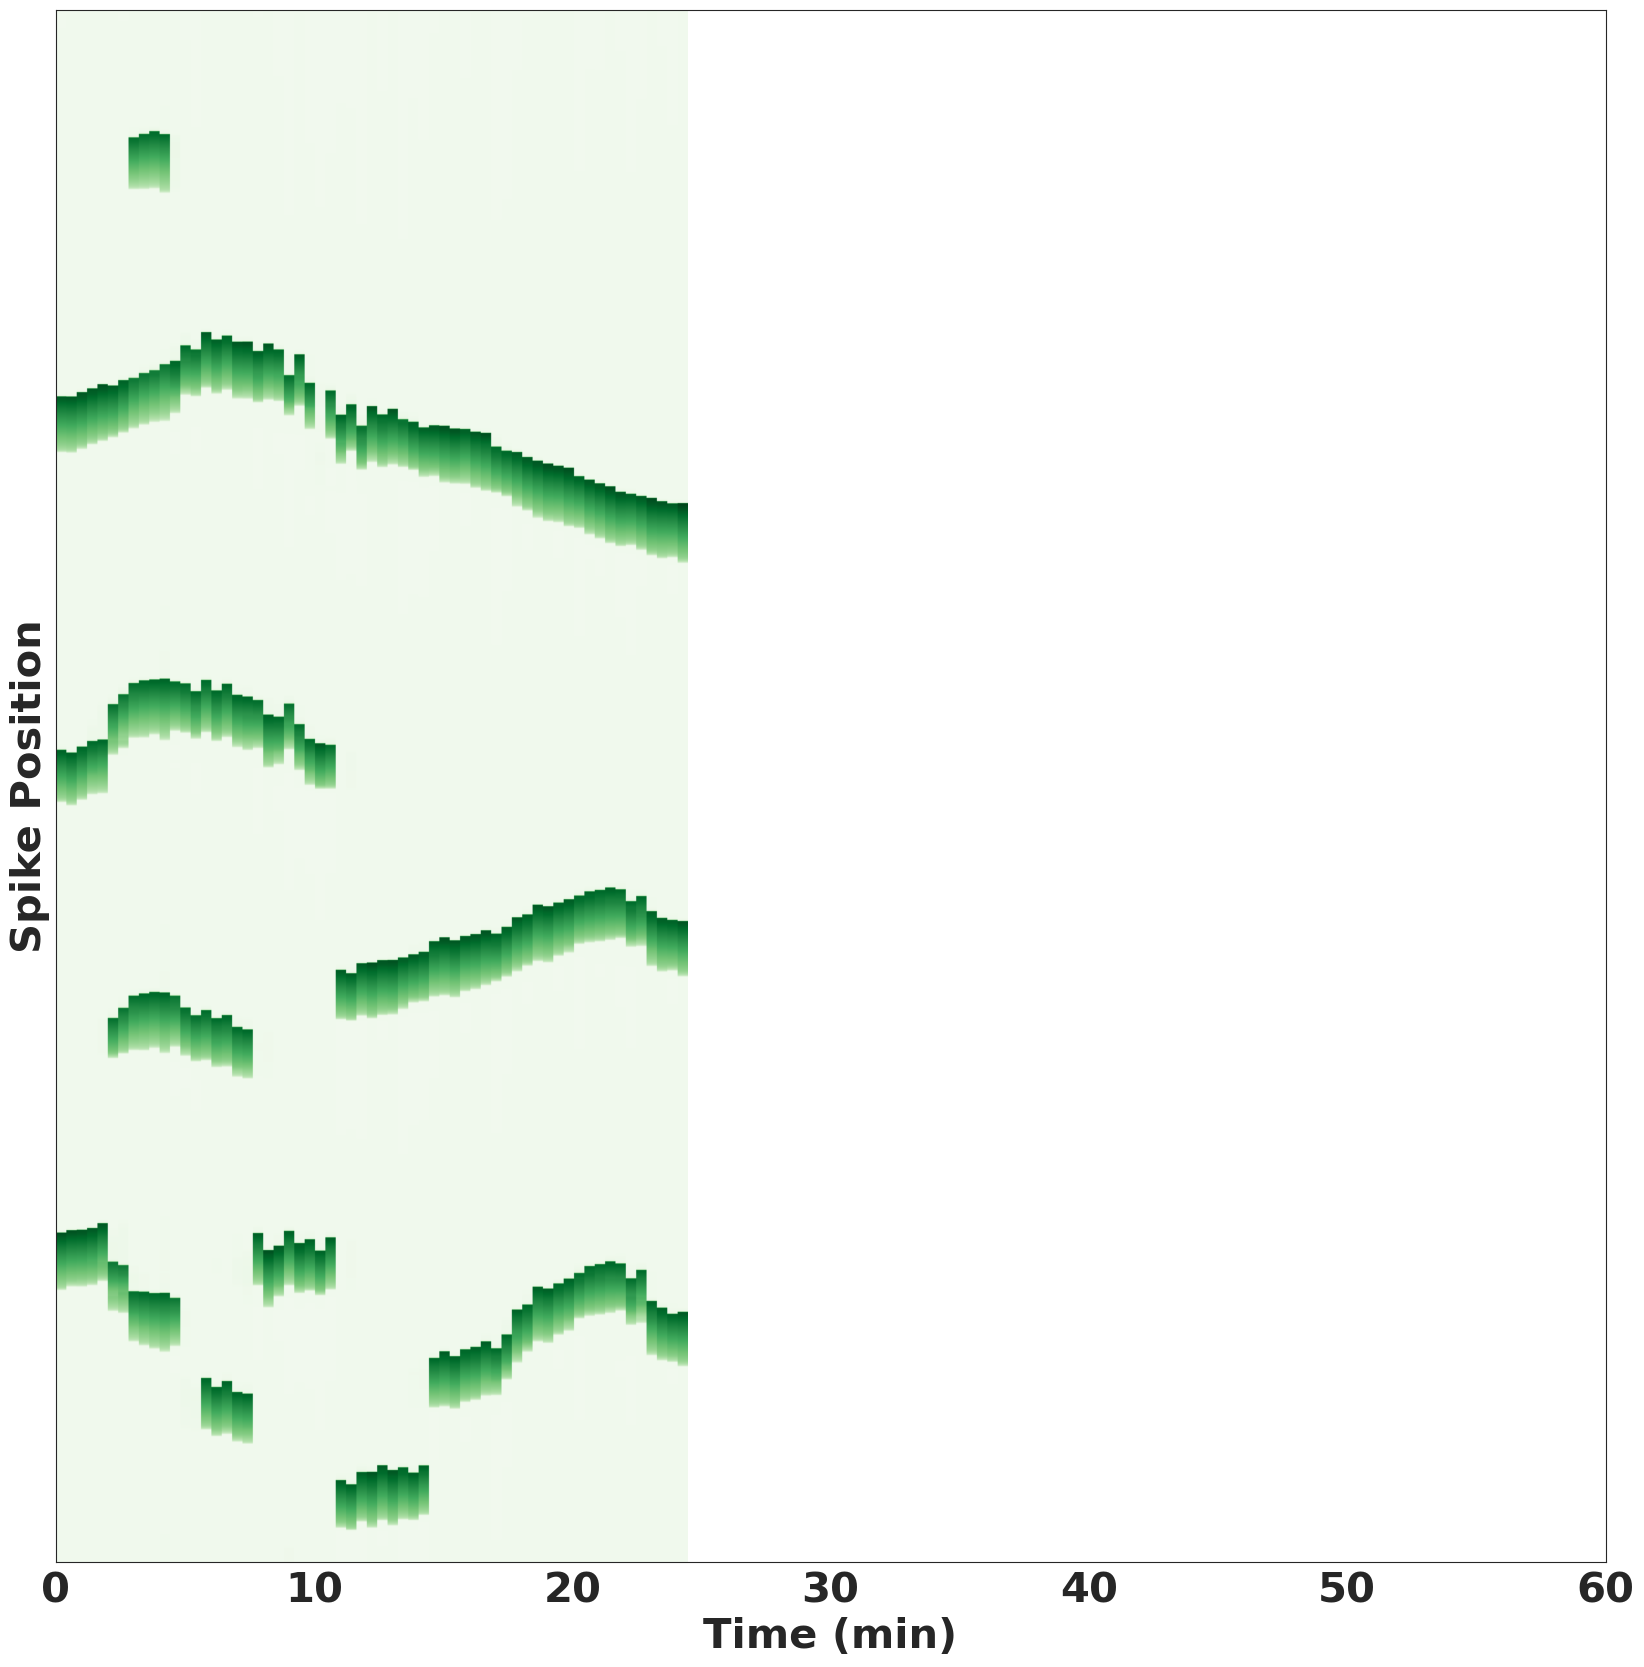

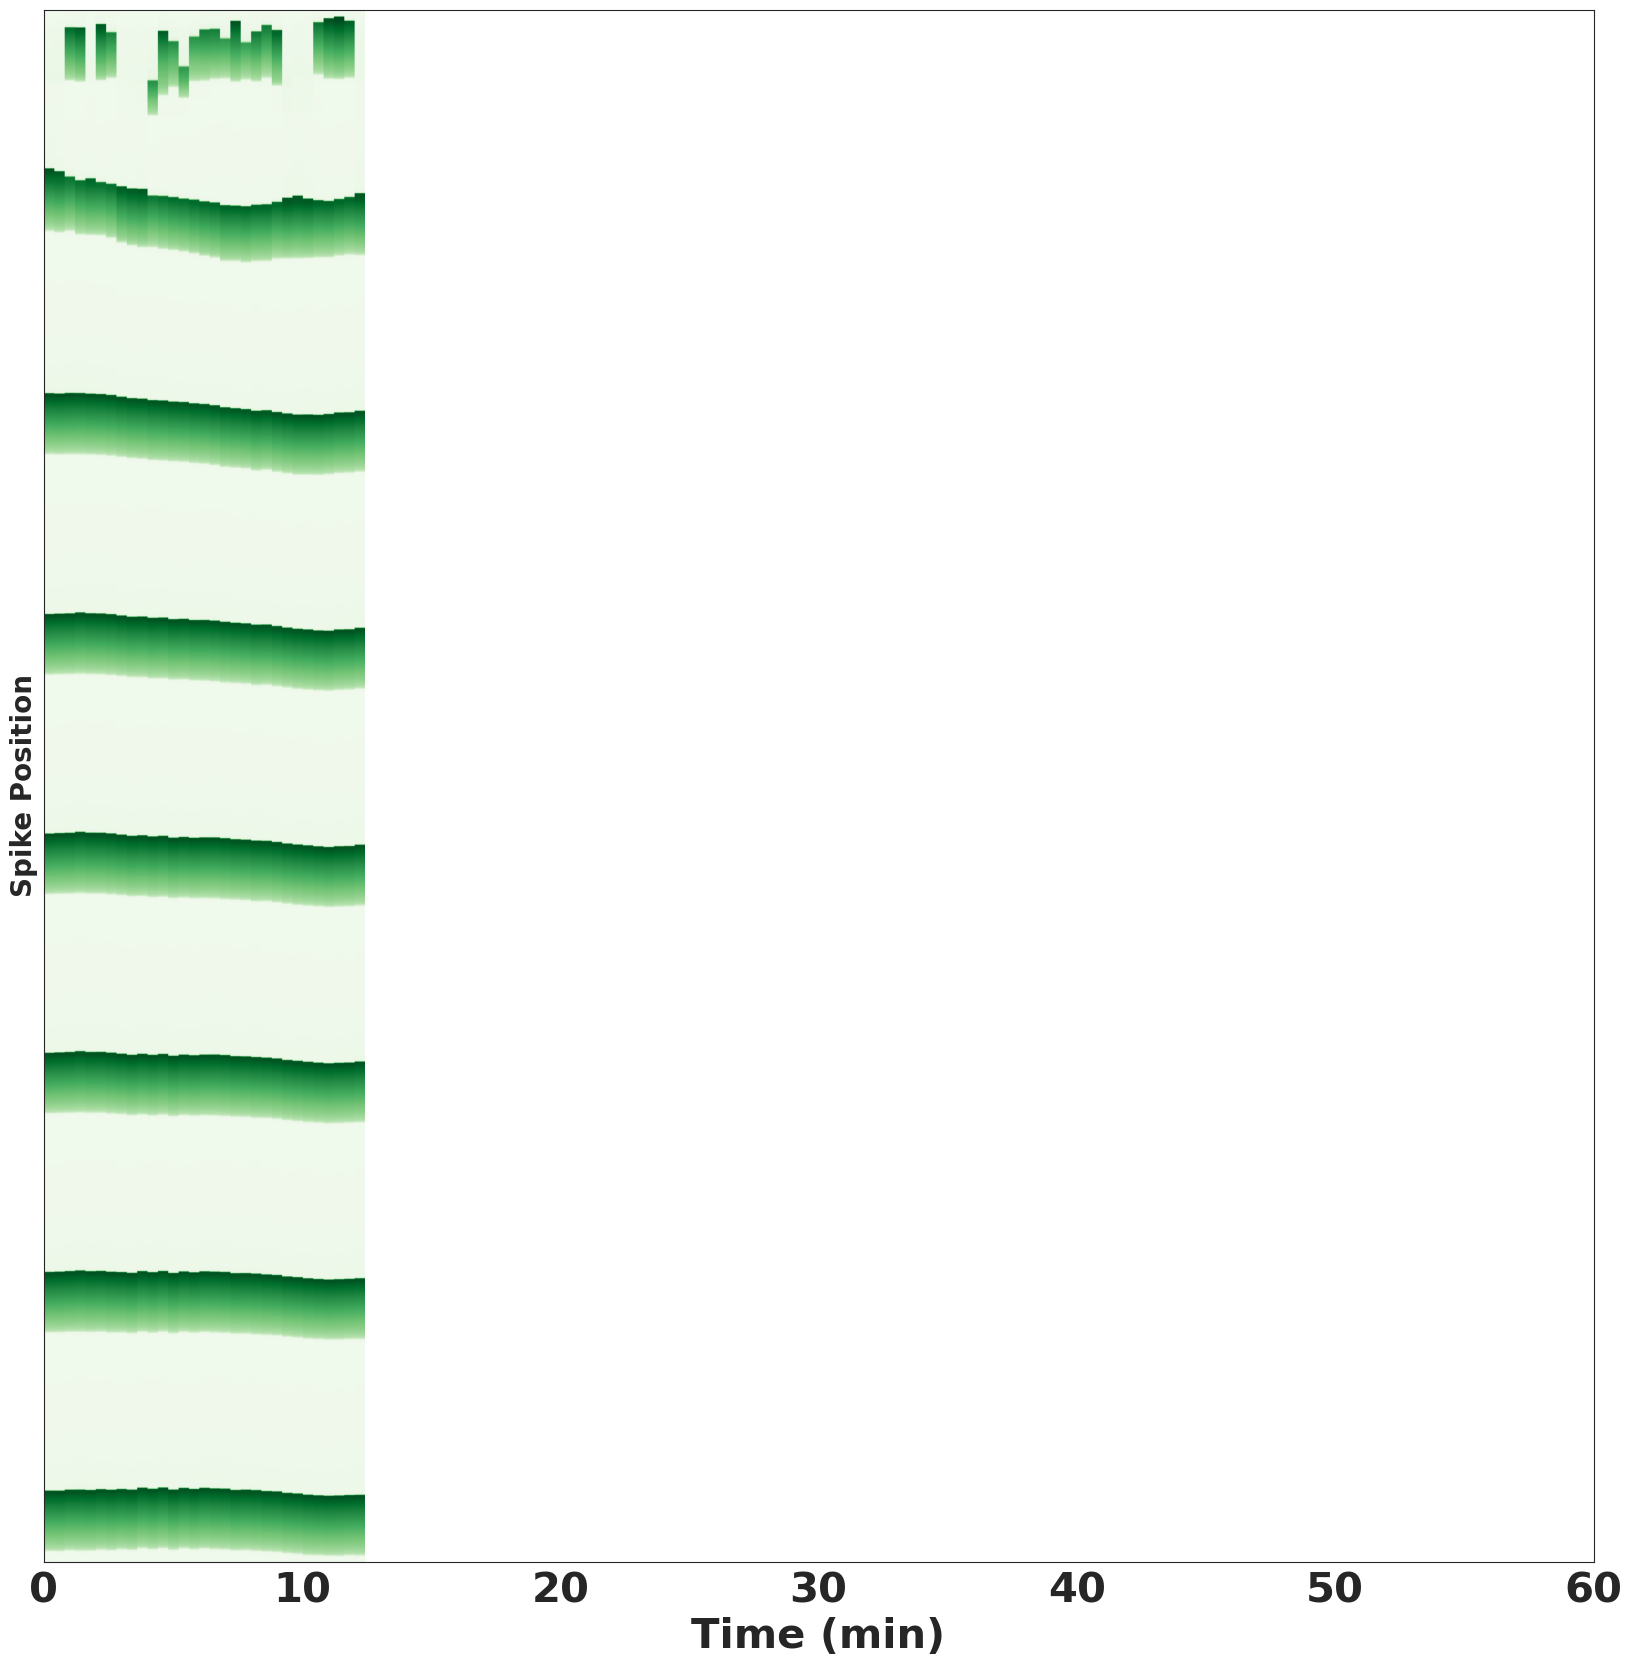

In [38]:
p_Spikes.draw_kymograph_transpose(saveFolderName)
p_ICT.draw_kymograph_transpose(saveFolderName)
p_ICW.draw_kymograph_transpose(saveFolderName)
p_Fluttering.draw_kymograph_transpose(saveFolderName)


# Output the simulation videos

In [12]:
# p_Spikes.make_animation(saveFolderName)
# p_ICT.make_animation(saveFolderName)
# p_ICW.make_animation(saveFolderName)
# p_Fluttering.make_animation(saveFolderName)

# p_Spikes_opt.make_animation(saveFolderName)
# p_ICT_opt.make_animation(saveFolderName)
# p_ICW_opt.make_animation(saveFolderName)
# p_Fluttering_opt.make_animation(saveFolderName)
